### MEV detection
In order to detect MEV 3 different methods are going to be used.


In [1]:
MERGE_BLOCK = 15537394

#### Gas price ordering (Pre+Post merge)
Check if the gas price in the transactions follows a descending order. Any deviation from it may indicate transactions added after the block was created.

In [2]:
from dask.distributed import Client
client = Client(n_workers=2, threads_per_worker=4, processes=True, memory_limit='20GB')
client

/opt/miniconda3/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 57549 instead
  warnings.warn(
2022-10-24 18:49:55,195 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/dask-worker-space/worker-wdsc27ae', purging
2022-10-24 18:49:55,195 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/dask-worker-space/worker-tuommq_d', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:57549/status,
Dashboard: http://127.0.0.1:57549/status,Workers: 2
Total threads: 8,Total memory: 37.25 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57558,Workers: 2
Dashboard: http://127.0.0.1:57549/status,Total threads: 8
Started: Just now,Total memory: 37.25 GiB
Comm: tcp://127.0.0.1:57687,Total threads: 4
Dashboard: http://127.0.0.1:57691/status,Memory: 18.63 GiB
Nanny: tcp://127.0.0.1:57568,


In [850]:
import pandas as pd

block_w_payload = pd.read_csv('block_with_payload.csv').drop_duplicates('block_number')
block_w_payload['timestamp'] = pd.to_datetime(block_w_payload['@timestamp'])

/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_44250/2018918296.py:3: DtypeWarning: Columns (2,13,28,32,34) have mixed types. Specify dtype option on import or set low_memory=False.
  block_w_payload = pd.read_csv('block_with_payload.csv').drop_duplicates('block_number')
/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_44250/2018918296.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  block_w_payload['timestamp'] = pd.to_datetime(block_w_payload['@timestamp'])


In [853]:
block_w_payload = block_w_payload.sort_values('block_number')

In [1102]:
import dask.dataframe as dd

tx_data = dd.read_csv('./transaction_data/tx_data*.csv', dtype={'gas_price': float, 'block_number': float, 'transaction_index': float}, assume_missing=True)[['gas_price', 'block_number', 'transaction_index', 'type']]

In [1103]:
tx_data

,gas_price,block_number,transaction_index,type
npartitions=1311,,,,
,float64,float64,float64,object
,...,...,...,...
...,...,...,...,...
,...,...,...,...
,...,...,...,...


In [859]:
def check_gas_price_ordering(data):
    data = data.sort_values(by='transaction_index')
    if (data.gas_price.reset_index(drop=True) == data.gas_price.sort_values(ascending=False).reset_index(drop=True)).all():
        # Gas price follows same ordering as transaction_index -> no MEV
        return False
    else:
        return True

In [860]:
# Group by block and check gas_price ordering
gas_price_mev = tx_data.groupby('block_number').apply(check_gas_price_ordering).compute()

/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_44250/1624916855.py:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  gas_price_mev = tx_data.groupby('block_number').apply(check_gas_price_ordering).compute()
/opt/miniconda3/lib/python3.9/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/opt/miniconda3/lib/python3.9/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/opt/miniconda3/lib/python3.9/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (1) have mixed types. Specify dtype optio

In [861]:
gas_price_mev = gas_price_mev.reset_index().rename(columns={0: 'mev_gas_ordering'})

In [862]:
gas_price_mev = block_w_payload.merge(gas_price_mev, on='block_number', how='left')

#### Last transaction (Post merge)
A last transaction from the proposer/miner to another address may indicate MEV rewards being transferred from the builder to the proposer.

In [1027]:
transaction_last = pd.read_csv('transaction_last.csv')

/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_44250/2269292136.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  transaction_last = pd.read_csv('transaction_last.csv')


In [1028]:
transaction_last = transaction_last[transaction_last.block_number > MERGE_BLOCK]

In [1030]:
# Merge block_w_payload and transaction_last on block_number
block_w_payload_w_tx_last = pd.merge(block_w_payload, transaction_last, on='block_number', how='left')

In [1031]:
# MEV tx logic
block_w_payload_w_tx_last['mev_last_tx'] = (block_w_payload_w_tx_last['miner'] == block_w_payload_w_tx_last['from'])

#### Relay API (Post merge)
Relay APIs return blocks submitted to validators.

In [870]:
relay_data = pd.read_csv('relay_data.csv')
relay_data = relay_data.rename(columns={'block_height':'slot'})

In [871]:
# MEV from relay api
relay_data['mev_relay_api'] = True
block_w_payload_w_relay = pd.merge(block_w_payload, relay_data, on='slot', how='left')
block_w_payload_w_relay['mev_relay_api'] = block_w_payload_w_relay['mev_relay_api'].fillna(False)

### Charting

##### MEV ratio

In [872]:
def mev_ratio(data, col):
    return data[col].sum() / data[col].count()

In [1037]:
gas_ratio = gas_price_mev[['timestamp', 'mev_gas_ordering']].set_index('timestamp').resample('H').apply(mev_ratio, 'mev_gas_ordering')
gas_trend = gas_ratio.rolling('3D').mean().resample('D').first().reset_index(drop=False).rename(columns={0: 'mev_trend'})
gas_ratio = gas_ratio.reset_index(drop=False).rename(columns={0: 'mev_ratio'})

tx_ratio = block_w_payload_w_tx_last[['timestamp', 'mev_last_tx']].set_index('timestamp').resample('H').apply(mev_ratio, 'mev_last_tx')
tx_trend = tx_ratio.rolling('3D').mean().resample('D').first().reset_index(drop=False).rename(columns={0: 'mev_trend'})
tx_ratio = tx_ratio.reset_index(drop=False).rename(columns={0: 'mev_ratio'})

relay_ratio = block_w_payload_w_relay[['timestamp', 'mev_relay_api']].set_index('timestamp').resample('H').apply(mev_ratio, 'mev_relay_api')
relay_trend = relay_ratio.rolling('3D').mean().resample('D').first().reset_index(drop=False).rename(columns={0: 'mev_trend'})
relay_ratio = relay_ratio.reset_index(drop=False).rename(columns={0: 'mev_ratio'})

In [1050]:
total_mev = block_w_payload_w_tx_last.merge(
    gas_price_mev.merge(block_w_payload_w_relay, on='block_number'),
    on='block_number'
)[['timestamp', 'block_number', 'proposer_address', 'slot', 'mev_gas_ordering', 'mev_last_tx', 'mev_relay_api']]

/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_44250/461807425.py:1: FutureWarning: Passing 'suffixes' which cause duplicate columns {'parent_hash_y', 'gas_limit_y', 'epoch_y', 'gas_used_y'} in the result is deprecated and will raise a MergeError in a future version.
  total_mev = block_w_payload_w_tx_last.merge(


In [1054]:
total_mev['mev'] = total_mev['mev_gas_ordering'].fillna(False) + total_mev['mev_last_tx'].fillna(False) + total_mev['mev_relay_api'].fillna(False)

In [1071]:
merge_time = block_w_payload[block_w_payload.block_number == MERGE_BLOCK]['timestamp'].squeeze()

In [1059]:
# Relays only make sense post merge
relay_ratio = relay_ratio[(relay_ratio.timestamp > merge_time) & (relay_ratio.timestamp < '2022-10-15')]
relay_trend = relay_trend[(relay_trend.timestamp > merge_time) & (relay_trend.timestamp < '2022-10-15')]

In [1060]:
# Last tx as MEV is not used pre merge
tx_ratio = tx_ratio[(tx_ratio.timestamp > merge_time) & (tx_ratio.timestamp < '2022-10-15')]
tx_trend = tx_trend[(tx_trend.timestamp > merge_time) & (tx_trend.timestamp < '2022-10-15')]

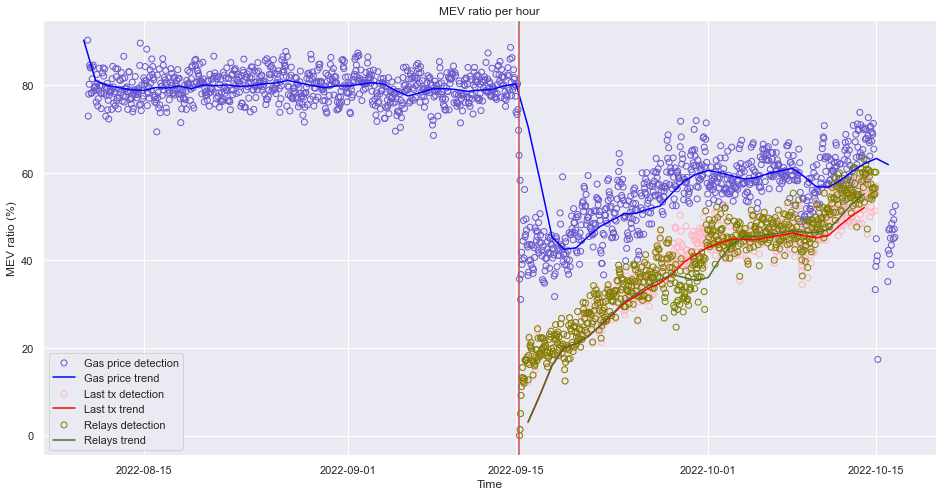

In [1061]:
# Resample and get MEV per hour
# Show Merge Block
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

fig = plt.figure(figsize=(16,8))
plt.scatter(gas_ratio['timestamp'], gas_ratio['mev_ratio']*100, facecolors='none', edgecolors='slateblue', label='Gas price detection')
plt.plot(gas_trend['timestamp'], gas_trend['mev_trend']*100, label='Gas price trend', color='blue')
plt.scatter(tx_ratio['timestamp'], tx_ratio['mev_ratio']*100, facecolors='none', edgecolors='lightpink', label='Last tx detection')
plt.plot(tx_trend['timestamp'], tx_trend['mev_trend']*100, label='Last tx trend', color='red')
plt.scatter(relay_ratio['timestamp'], relay_ratio['mev_ratio']*100,  facecolors='none', edgecolors='olive', label='Relays detection')
plt.plot(relay_trend['timestamp'], relay_trend['mev_trend']*100, label='Relays trend', color='darkolivegreen')
plt.axvline(merge_time, color='r')
plt.legend()
plt.xlabel('Time')
plt.ylabel('MEV ratio (%)')
plt.title('MEV ratio per hour')
plt.show()

#### Miner / Validators Distribution

In [1072]:
total_miners_all_mev = pd.concat([
    gas_price_mev[['timestamp', 'miner', 'mev_gas_ordering']], 
    block_w_payload_w_tx_last[['timestamp', 'miner', 'mev_last_tx']],
    block_w_payload_w_relay[['timestamp', 'miner', 'mev_relay_api']]
    ])


In [1073]:
total_miners_all_mev['mev'] = total_miners_all_mev['mev_gas_ordering'].fillna(False) + total_miners_all_mev['mev_last_tx'].fillna(False) + total_miners_all_mev['mev_relay_api'].fillna(False)

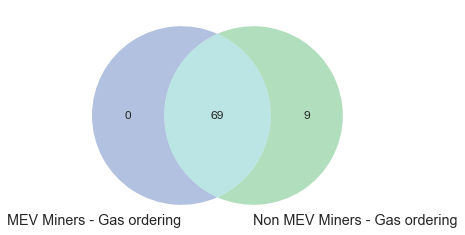

In [1099]:
from matplotlib_venn import venn3, venn2_circles, venn2_unweighted, venn2

# intersection are validators / miners who have used MEV in some blocks but no alls

c = ('#3E64AF', '#3EAF5D')

# mev_miners_all = set(total_miners_all_mev[(total_miners_all_mev.timestamp < merge_time) & (total_miners_all_mev.mev == True)]['miner'].unique())
# non_mev_miners_all = set(total_miners_all_mev[(total_miners_all_mev.timestamp < merge_time) & (total_miners_all_mev.mev != True)]['miner'].unique())

mev_miners_gas = set(total_miners_all_mev[(total_miners_all_mev.timestamp < merge_time) & (total_miners_all_mev.mev_gas_ordering == True)]['miner'].unique())
non_mev_miners_gas = set(total_miners_all_mev[(total_miners_all_mev.timestamp < merge_time) & (total_miners_all_mev.mev_gas_ordering != True)]['miner'].unique())

# venn2_unweighted([mev_miners_all, non_mev_miners_all], ('MEV Miners', 'Non MEV Miners'), set_colors=c)


venn2_unweighted([mev_miners_gas, non_mev_miners_gas], ('MEV Miners - Gas ordering', 'Non MEV Miners - Gas ordering'), set_colors=c)
plt.show()

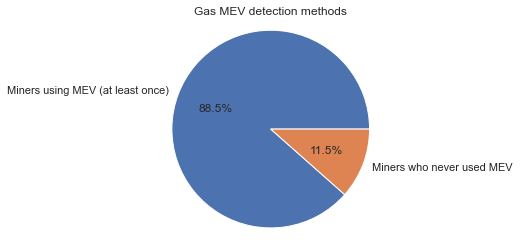

In [1077]:
labels = ['Miners using MEV (at least once)', 'Miners who never used MEV']
sizes = [len(mev_miners_gas), len(non_mev_miners_gas - mev_miners_gas)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Gas MEV detection methods')

plt.show()

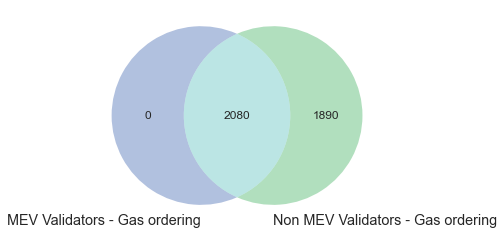

In [1094]:

# mev_vals_all = set(total_miners_all_mev[(total_miners_all_mev.timestamp < merge_time) & (total_miners_all_mev.mev == True)]['miner'].unique())
# non_mev_vals_all = set(total_miners_all_mev[(total_miners_all_mev.timestamp > merge_time) & (total_miners_all_mev.mev != True)]['miner'].unique())

mev_vals_gas = set(total_miners_all_mev[(total_miners_all_mev.timestamp > merge_time) & (total_miners_all_mev.mev_gas_ordering == True)]['miner'].unique())
non_mev_vals_gas = set(total_miners_all_mev[(total_miners_all_mev.timestamp > merge_time) & (total_miners_all_mev.mev_gas_ordering != True)]['miner'].unique())

# venn2([mev_vals, non_mev_vals], ('MEV Validators', 'Non MEV Validators'), set_colors=c)
venn2_unweighted([mev_vals_gas, non_mev_vals_gas], ('MEV Validators - Gas ordering', 'Non MEV Validators - Gas ordering'), set_colors=c)

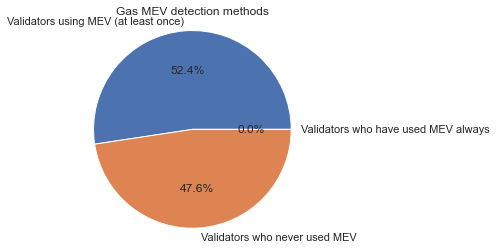

In [1095]:
labels = ['Validators using MEV (at least once)', 'Validators who never used MEV', 'Validators who have used MEV always']
sizes = [len(mev_vals_gas), len(non_mev_vals_gas - mev_vals_gas), len(mev_vals_gas - non_mev_vals_gas)]

fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels=labels, autopct='%1.1f%%')
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Gas MEV detection methods')

plt.show()

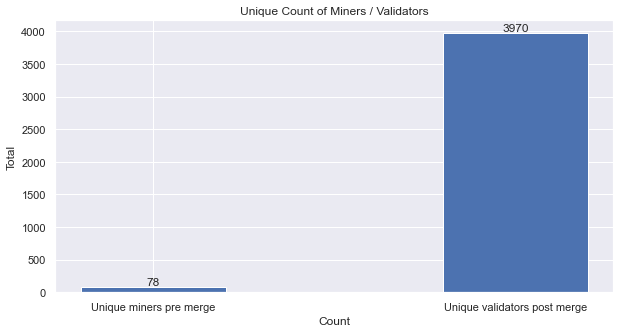

In [1098]:
fig, ax = plt.subplots(figsize = (10, 5))

labels = ['Unique miners pre merge', 'Unique validators post merge']
values = [
    len(total_miners_all_mev[total_miners_all_mev.timestamp < merge_time]['miner'].unique()),
    len(total_miners_all_mev[total_miners_all_mev.timestamp > merge_time]['miner'].unique())
] 
 
# creating the bar plot
p1 = ax.bar(labels, values,width = 0.4)

ax.bar_label(p1)
 
plt.xlabel("Count")
plt.ylabel("Total")
plt.title("Unique Count of Miners / Validators")
plt.show()

### Transaction count

In [1105]:
def transaction_counts(data):
    return len(data.transaction_index.unique())

In [1509]:
tx_count_groupby = tx_data.groupby(['block_number', 'type']).apply(transaction_counts).compute()

/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_44250/3784950626.py:1: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  tx_count_groupby = tx_data.groupby(['block_number', 'type']).apply(transaction_counts).compute()
/opt/miniconda3/lib/python3.9/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/opt/miniconda3/lib/python3.9/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = reader(bio, **kwargs)
/opt/miniconda3/lib/python3.9/site-packages/dask/dataframe/io/csv.py:193: DtypeWarning: Columns (1) have mixed types. Specify dtyp

In [1512]:
tx_count_groupby = tx_count_groupby.reset_index().rename(columns={0: 'transactions_count'})

In [1513]:
tx_count_groupby = tx_count_groupby.sort_values('block_number')

In [1520]:
tx_count = (tx_count_groupby.merge(gas_price_mev[['block_number', 'mev_gas_ordering']], on=['block_number'], how='outer')
    .merge(block_w_payload_w_tx_last[['timestamp', 'block_number', 'mev_last_tx']].drop_duplicates('block_number'), on=['block_number'], how='outer')
    .merge(block_w_payload_w_relay[['timestamp', 'block_number', 'mev_relay_api']].drop_duplicates('block_number'), on=['timestamp', 'block_number'], how='outer')).dropna()


In [1522]:
tx_count_total = (gas_price_mev[['timestamp', 'transactions_count', 'block_number', 'mev_gas_ordering']].drop_duplicates('block_number')
    .merge(block_w_payload_w_tx_last[['block_number', 'mev_last_tx']].drop_duplicates('block_number'), on='block_number', how='outer')
    .merge(block_w_payload_w_relay[['block_number', 'mev_relay_api']].drop_duplicates('block_number'), on='block_number', how='outer'))

In [1560]:
tx_count = tx_count.merge(tx_count.groupby('block_number')['transactions_count'].sum().reset_index().rename(columns={'transactions_count': 'total_tx_count'}), on='block_number', how='left')

In [1552]:
len(tx_count_total.block_number.unique())

431063

In [1524]:
tx_count_total = tx_count_total[tx_count_total.block_number.isin(tx_count.block_number.tolist())]

In [1527]:
tx_count_total['mev'] = (tx_count_total['mev_gas_ordering'].fillna(False) + tx_count_total['mev_last_tx'].fillna(False) + tx_count_total['mev_relay_api'].fillna(False)).astype(bool)

/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_44250/1067304547.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_count_total['mev'] = (tx_count_total['mev_gas_ordering'].fillna(False) + tx_count_total['mev_last_tx'].fillna(False) + tx_count_total['mev_relay_api'].fillna(False)).astype(bool)


In [1528]:
tx_count['mev'] = (tx_count['mev_gas_ordering'].fillna(False) + tx_count['mev_last_tx'].fillna(False) + tx_count['mev_relay_api'].fillna(False)).astype(bool)

#### TPS

In [1531]:
((tx_count_total[(tx_count_total.timestamp < merge_time)].set_index('timestamp').resample('D')['transactions_count'].sum() / (24*3600)).mean(), 
(tx_count_total[(tx_count_total.timestamp > merge_time)].set_index('timestamp').resample('D')['transactions_count'].sum() / (24*3600)).mean())

(12.112913225725729, 12.729653862847222)

In [1532]:
tx_count_total['bit'] = tx_count_total.sort_values('timestamp')['timestamp'].diff().dt.seconds

/var/folders/lp/_rx86ryd7rb15mj50jgh67c80000gn/T/ipykernel_44250/2821723647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tx_count_total['bit'] = tx_count_total.sort_values('timestamp')['timestamp'].diff().dt.seconds


In [1533]:
# Pre TPS
(tx_count_total[(tx_count_total.timestamp < merge_time) & (tx_count_total.mev == True)]['transactions_count'].sum() / 
tx_count_total[(tx_count_total.timestamp < merge_time) & (tx_count_total.mev == True)]['bit'].sum(), 
tx_count_total[(tx_count_total.timestamp < merge_time) & (tx_count_total.mev == False)]['transactions_count'].sum() / 
tx_count_total[(tx_count_total.timestamp < merge_time) & (tx_count_total.mev == False)]['bit'].sum())


(13.855093837320895, 6.792300905026065)

In [1534]:
# Post TPS
(tx_count_total[(tx_count_total.timestamp > merge_time) & (tx_count_total.mev == True)]['transactions_count'].sum() / 
tx_count_total[(tx_count_total.timestamp > merge_time) & (tx_count_total.mev == True)]['bit'].sum(), 
tx_count_total[(tx_count_total.timestamp > merge_time) & (tx_count_total.mev == False)]['transactions_count'].sum() / 
tx_count_total[(tx_count_total.timestamp > merge_time) & (tx_count_total.mev == False)]['bit'].sum())

(15.37681407381521, 9.296971327179719)

#### Blocks with no transactions

In [1535]:
no_tx_pre = tx_count_total[(tx_count_total.timestamp < merge_time) & (tx_count_total.transactions_count == 0)]
no_tx_post = tx_count_total[(tx_count_total.timestamp > merge_time) & (tx_count_total.transactions_count == 0)]

#### Rest of blocks

In [1538]:
tx_count_total = tx_count_total[tx_count_total.transactions_count > 1]

In [1539]:
# Max txs
(tx_count_total[tx_count_total.timestamp < merge_time].transactions_count.max(), tx_count_total[tx_count_total.timestamp > merge_time].transactions_count.max())

(1418.0, 1410.0)

Text(0.5, 1.0, 'Transaction Count by Type - Pre Merge No MEV')

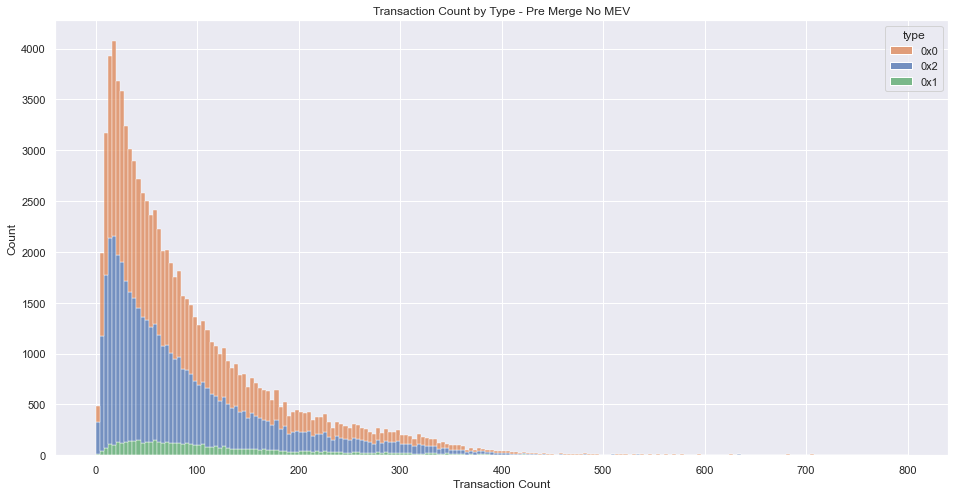

In [1650]:

fig = plt.figure(figsize=(16,8))
sns.histplot(data=tx_count[(tx_count.timestamp < merge_time) & (tx_count.mev==False)], x="total_tx_count", 
            hue='type', stat='count', bins=200, binrange=(0.1,800), palette=["C1", "C0", "C2"], multiple='stack')
plt.xlabel('Transaction Count')
plt.title('Transaction Count by Type - Pre Merge No MEV')

Text(0.5, 1.0, 'Transaction Count by Type - Pre Merge MEV')

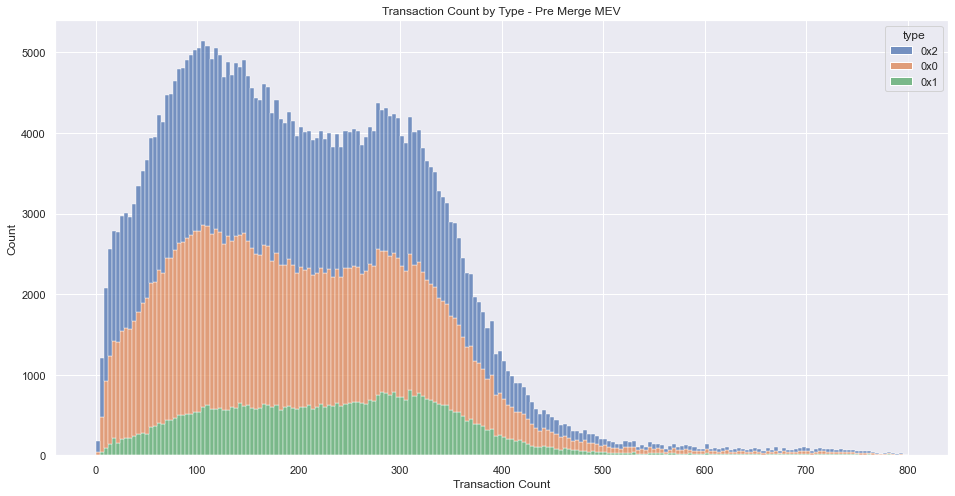

In [1645]:
palette = {
    (True, '0x0'): '#8abda7',
    (True, '0x1'): '#1d573e',
    (True, '0x2'): '#4BE9A6',
    (False, '0x0'): '#fb705c',
    (False, '0x1'): '#5c2a23',
    (False, '0x2'): '#bf928c'
}

fig = plt.figure(figsize=(16,8))
sns.histplot(data=tx_count[(tx_count.timestamp < merge_time) & (tx_count.mev==True)], x="total_tx_count", 
            hue='type', stat='count', bins=200, binrange=(0.1,800), palette=["C0", "C1", "C2"], multiple='stack')
plt.xlabel('Transaction Count')
plt.title('Transaction Count by Type - Pre Merge MEV')

Text(0.5, 1.0, 'Transaction Count Pre merge')

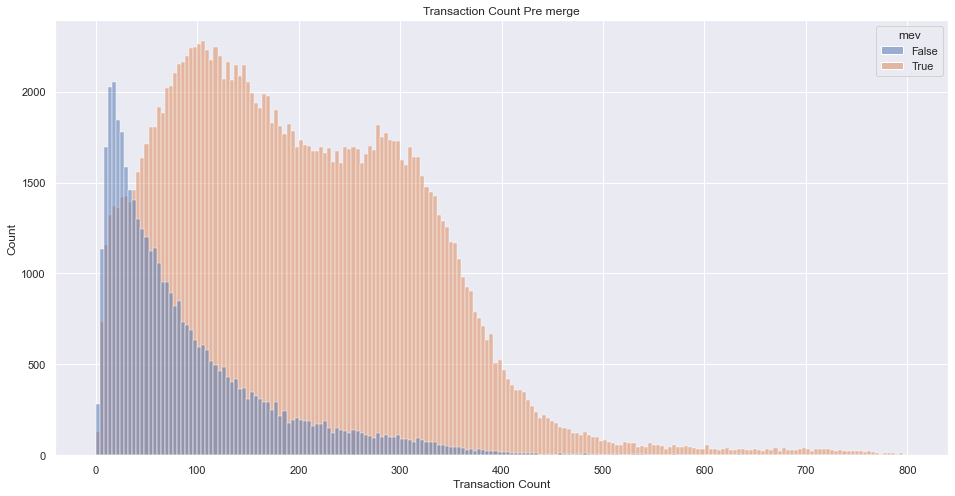

In [1717]:
fig = plt.figure(figsize=(16,8))
sns.histplot(data=tx_count_total[tx_count_total.timestamp < merge_time], x="transactions_count", hue="mev", stat='count', bins=200, binrange=(0.1,800))
plt.xlabel('Transaction Count')
plt.title("Transaction Count Pre merge")

Text(0.5, 1.0, 'Transaction Count Pre merge')

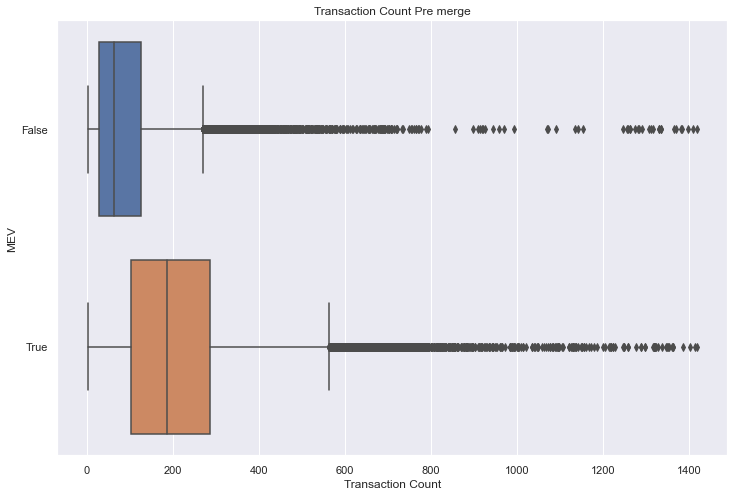

In [1718]:
fig = plt.figure(figsize=(12,8))
sns.boxplot(data=tx_count_total[(tx_count_total.timestamp < merge_time)], x="transactions_count", y="mev", orient="h")
plt.xlabel('Transaction Count')
plt.ylabel('MEV')
plt.title("Transaction Count Pre merge")

Text(0.5, 1.0, 'Transaction Count by Type - Post Merge No MEV')

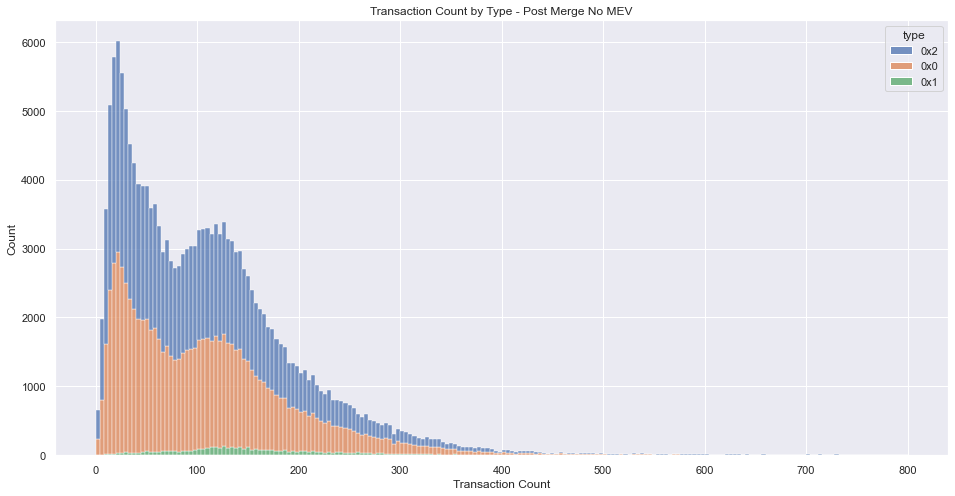

In [1646]:
fig = plt.figure(figsize=(16,8))
sns.histplot(data=tx_count[(tx_count.timestamp > merge_time) & (tx_count.mev==False)], x="total_tx_count", 
            hue='type', stat='count', bins=200, binrange=(0.1,800), palette=["C0", "C1", "C2"], multiple='stack')
plt.xlabel('Transaction Count')
plt.title('Transaction Count by Type - Post Merge No MEV')

Text(0.5, 1.0, 'Transaction Count by Type - Post Merge MEV')

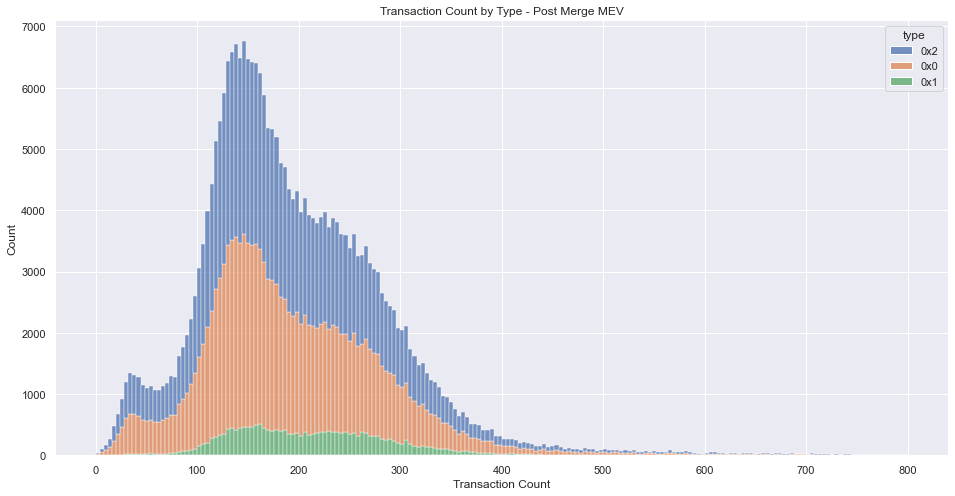

In [1706]:
fig = plt.figure(figsize=(16,8))
sns.histplot(data=tx_count[(tx_count.timestamp > merge_time) & (tx_count.mev==True)], x="total_tx_count", 
            hue='type', stat='count', bins=200, binrange=(0.1,800), palette=["C0", "C1", "C2"], multiple='stack')
plt.xlabel('Transaction Count')
plt.title('Transaction Count by Type - Post Merge MEV')

In [1674]:
(29030/ 162515, 201/ 162515, 133284/ 162515)

(0.17862966495400426, 0.0012368089099467742, 0.820133526136049)

In [1703]:
def expand_type_count(data):
    expanded = []
    for t in data.type.unique():
        expanded += [t] * int(data[data.type == t].transactions_count.squeeze())

    return expanded

In [1704]:
# Expand type for each block by the amount of transactions_count
tx_count[(tx_count.timestamp > merge_time) & (tx_count.mev==True) & (tx_count.total_tx_count < 103)& (tx_count.total_tx_count > 97)].groupby('block_number').apply(expand_type_count)

block_number
15537436.0    [0x0, 0x0, 0x0, 0x0, 0x0, 0x0, 0x0, 0x0, 0x0, ...
15537488.0    [0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, ...
15537727.0    [0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, ...
15537915.0    [0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, ...
15538502.0    [0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, ...
                                    ...                        
15761078.0    [0x1, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, ...
15761083.0    [0x0, 0x0, 0x0, 0x0, 0x0, 0x0, 0x0, 0x2, 0x2, ...
15761142.0    [0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, ...
15761174.0    [0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, ...
15761290.0    [0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, 0x2, ...
Length: 1624, dtype: object

In [1682]:
tx_count[(tx_count.timestamp > merge_time) & (tx_count.mev==True) & (tx_count.total_tx_count < 103)& (tx_count.total_tx_count > 97)].groupby('type').count()

,block_number,transactions_count,mev_gas_ordering,timestamp,mev_last_tx,mev_relay_api,mev,total_tx_count
type,,,,,,,,
0x0,1624,1624,1624,1624,1624,1624,1624,1624
0x1,162,162,162,162,162,162,162,162
0x2,1624,1624,1624,1624,1624,1624,1624,1624


In [1681]:
tx_count[(tx_count.timestamp > merge_time) & (tx_count.mev==True) & (tx_count.total_tx_count < 103)& (tx_count.total_tx_count > 97)].groupby('type').sum()

,block_number,transactions_count,mev_last_tx,mev_relay_api,mev,total_tx_count
type,,,,,,
0x0,2.543395e+10,29030.0,920,913,1624,162515.0
0x1,2.535412e+09,201.0,126,126,162,16231.0
0x2,2.543395e+10,133284.0,920,913,1624,162515.0


Text(0.5, 1.0, 'Transaction Count Post merge')

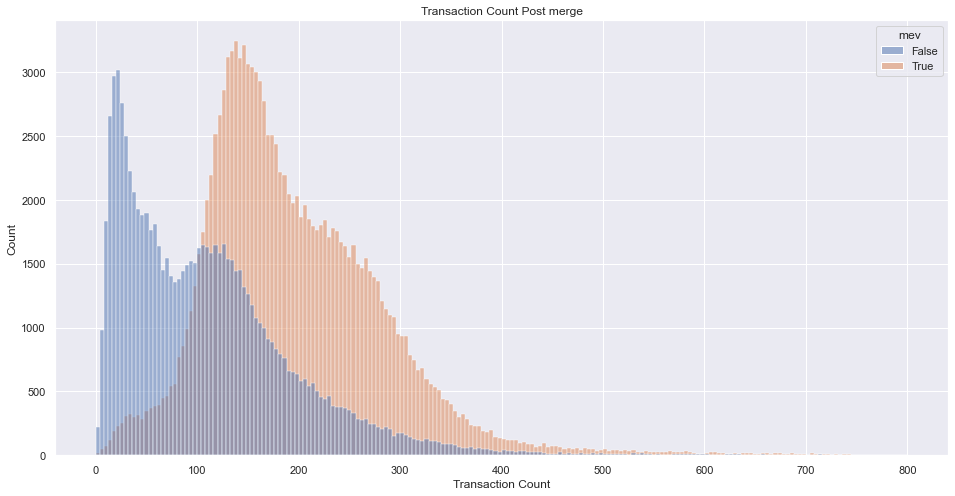

2022-10-27 20:46:25,514 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 6 memory: 605 MB fds: 151>>
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.9/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/opt/miniconda3/lib/python3.9/site-packages/distributed/system_monitor.py", line 133, in update
    net_ioc = psutil.net_io_counters()
  File "/opt/miniconda3/lib/python3.9/site-packages/psutil/__init__.py", line 2114, in net_io_counters
    rawdict = _psplatform.net_io_counters()
OSError: [Errno 12] Cannot allocate memory
2022-10-28 08:58:16,899 - tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 6 memory: 501 MB fds: 151>>
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.9/site-packages/tornado/ioloop.py", line 905, in _run
    return self.callback()
  File "/opt/miniconda3/lib/pytho

In [1719]:
fig = plt.figure(figsize=(16,8))
sns.histplot(data=tx_count_total[tx_count_total.timestamp > merge_time], x="transactions_count", hue="mev", stat='count', bins=200, binrange=(0.1,800))
plt.xlabel('Transaction Count')
plt.title("Transaction Count Post merge")

Text(0.5, 1.0, 'Transaction Count Post merge')

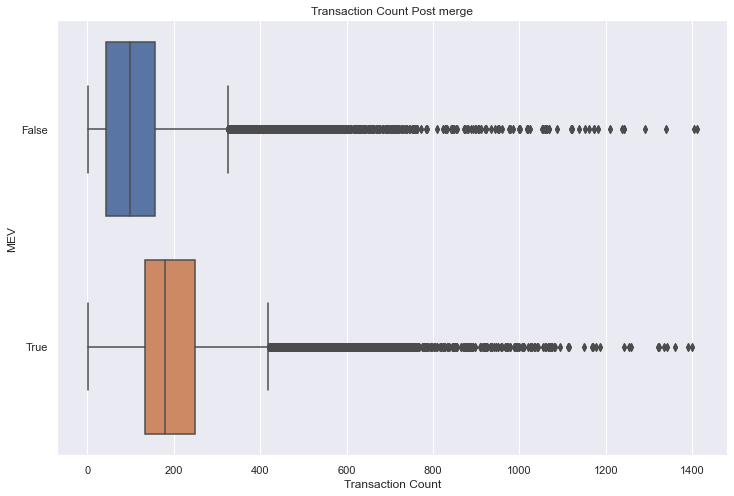

In [1565]:
fig = plt.figure(figsize=(12,8))
sns.boxplot(data=tx_count[(tx_count.timestamp > merge_time)], x="total_tx_count", y="mev", orient="h")
plt.xlabel('Transaction Count')
plt.ylabel('MEV')
plt.title("Transaction Count Post merge")

### Gas used

In [1236]:
gas_used = (gas_price_mev[['timestamp', 'transactions_count', 'block_number', 'gas_used', 'mev_gas_ordering']].drop_duplicates('block_number')
    .merge(block_w_payload_w_tx_last[['block_number', 'mev_last_tx']].drop_duplicates('block_number'), on='block_number')
    .merge(block_w_payload_w_relay[['block_number', 'mev_relay_api']].drop_duplicates('block_number'), on='block_number'))

In [1237]:
gas_used = gas_used[~gas_used.gas_used.isna()]

In [1238]:
gas_used['mev'] = gas_used['mev_gas_ordering'].fillna(False) + gas_used['mev_last_tx'].fillna(False) + gas_used['mev_relay_api'].fillna(False)

In [1239]:
gas_used = gas_used[['timestamp', 'gas_used', 'mev']].drop_duplicates()

Text(0.5, 1.0, 'Gas Used Pre merge')

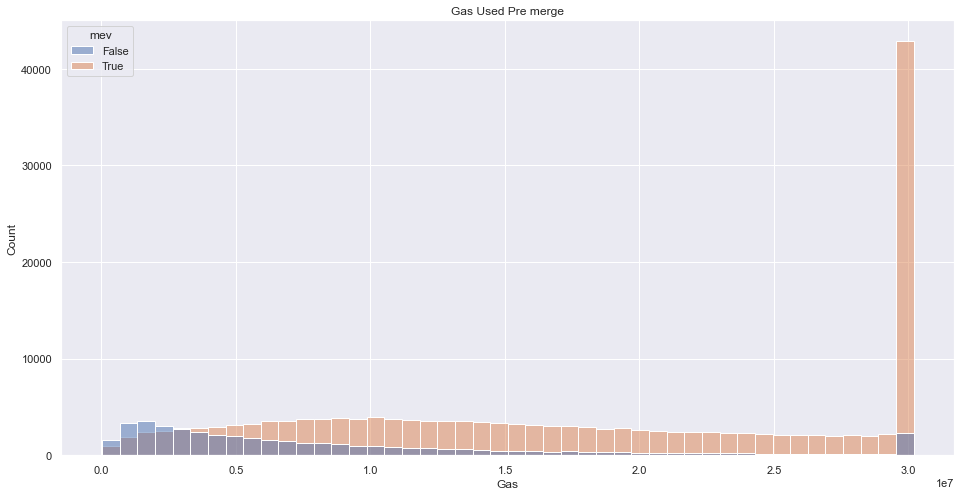

In [1240]:
fig = plt.figure(figsize=(16,8))
sns.histplot(data=gas_used[(gas_used.timestamp < merge_time) & (gas_used.gas_used > 0)], x="gas_used", hue="mev", stat='count')
plt.xlabel('Gas')
plt.title("Gas Used Pre merge")

Text(0.5, 1.0, 'Gas Used Post merge')

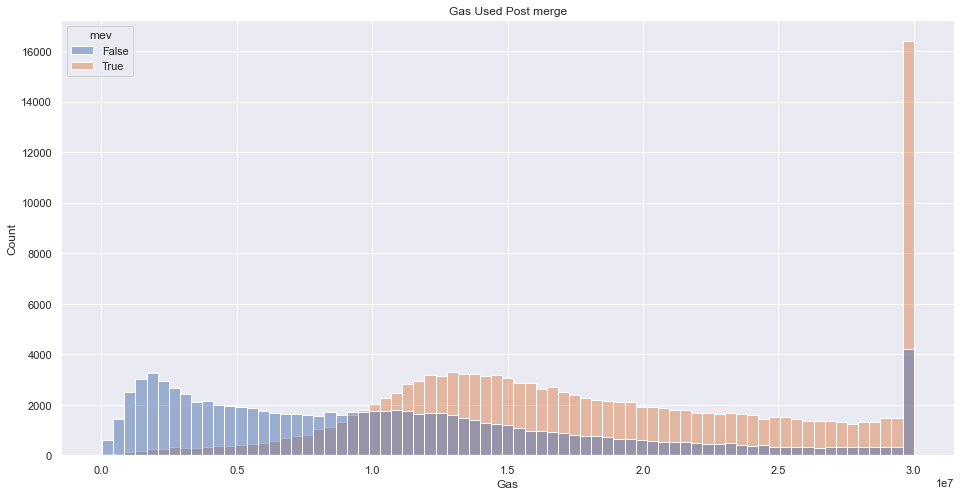

In [1241]:
fig = plt.figure(figsize=(16,8))
sns.histplot(data=gas_used[(gas_used.timestamp > merge_time) & (gas_used.gas_used > 0)], x="gas_used", hue="mev", stat='count')
plt.xlabel('Gas')
plt.title("Gas Used Post merge")

#### Block Reward

In [1242]:
block_reward = (gas_price_mev[['timestamp', 'transactions_count', 'block_number', 'block_reward', 'mev_gas_ordering']].drop_duplicates('block_number')
    .merge(block_w_payload_w_tx_last[['block_number', 'mev_last_tx']].drop_duplicates('block_number'), on='block_number')
    .merge(block_w_payload_w_relay[['block_number', 'mev_relay_api']].drop_duplicates('block_number'), on='block_number'))

In [1243]:
block_reward['mev'] = block_reward['mev_gas_ordering'].fillna(False) + block_reward['mev_last_tx'].fillna(False) + block_reward['mev_relay_api'].fillna(False)

In [1244]:
block_reward['block_reward'] = block_reward['block_reward'].astype(float)

In [1245]:
block_reward['block_reward'] = block_reward['block_reward'] / (10**(18))

In [1246]:
block_reward.loc[block_reward.timestamp < merge_time, 'block_reward'] = block_reward[block_reward.timestamp < merge_time]['block_reward'] - 2

Text(0.5, 1.0, 'Block Reward Pre merge')

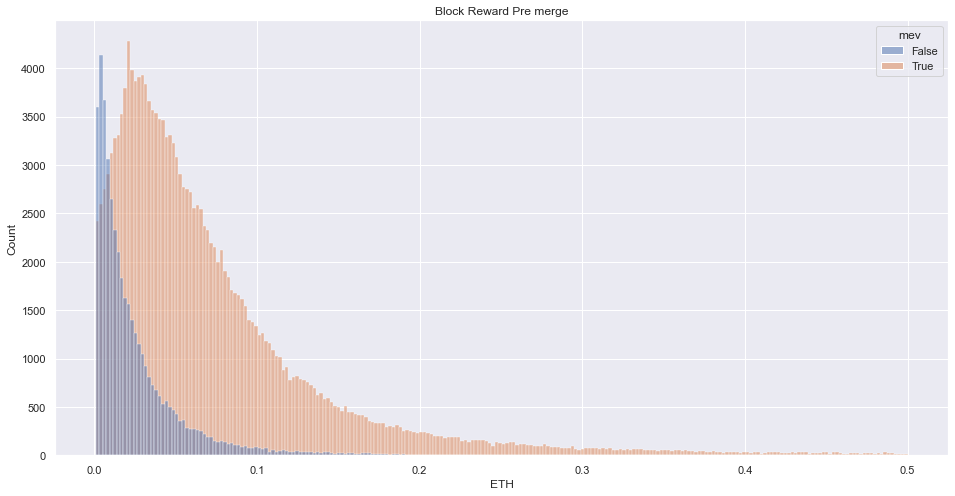

In [1247]:
fig = plt.figure(figsize=(16,8))
sns.histplot(data=block_reward[block_reward.timestamp < merge_time], x="block_reward", hue="mev", binrange=(0.001, 0.5), stat='count')
plt.xlabel('ETH')
plt.title("Block Reward Pre merge")

Text(0.5, 1.0, 'Block Reward Post merge')

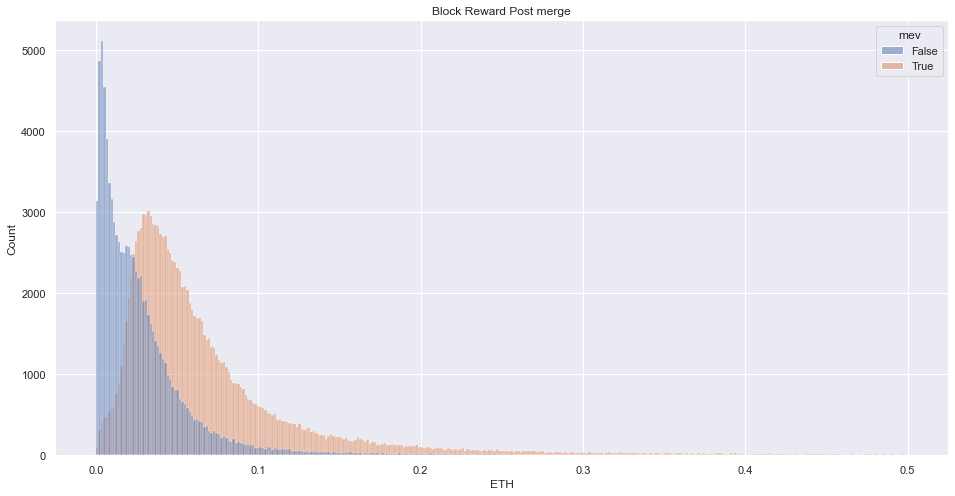

In [1248]:
fig = plt.figure(figsize=(16,8))
sns.histplot(data=block_reward[block_reward.timestamp > merge_time], x="block_reward", hue="mev", binrange=(0, 0.5), stat='count')
plt.xlabel('ETH')
plt.title("Block Reward Post merge")

#### Transaction Fee 

In [1249]:
tx_fee = (gas_price_mev[['timestamp', 'transactions_count', 'block_number', 'transaction_fees', 'mev_gas_ordering']].drop_duplicates('block_number')
    .merge(block_w_payload_w_tx_last[['block_number', 'mev_last_tx']].drop_duplicates('block_number'), on='block_number')
    .merge(block_w_payload_w_relay[['block_number', 'mev_relay_api']].drop_duplicates('block_number'), on='block_number'))

In [1250]:
tx_fee['mev'] = tx_fee['mev_gas_ordering'].fillna(False) + tx_fee['mev_last_tx'].fillna(False) + tx_fee['mev_relay_api'].fillna(False)

In [1251]:
tx_fee['transaction_fees'] = tx_fee['transaction_fees'].astype(float)
tx_fee['transaction_fees'] = tx_fee['transaction_fees'] / (10**(18))

Text(0.5, 1.0, 'Transaction Fee Pre merge')

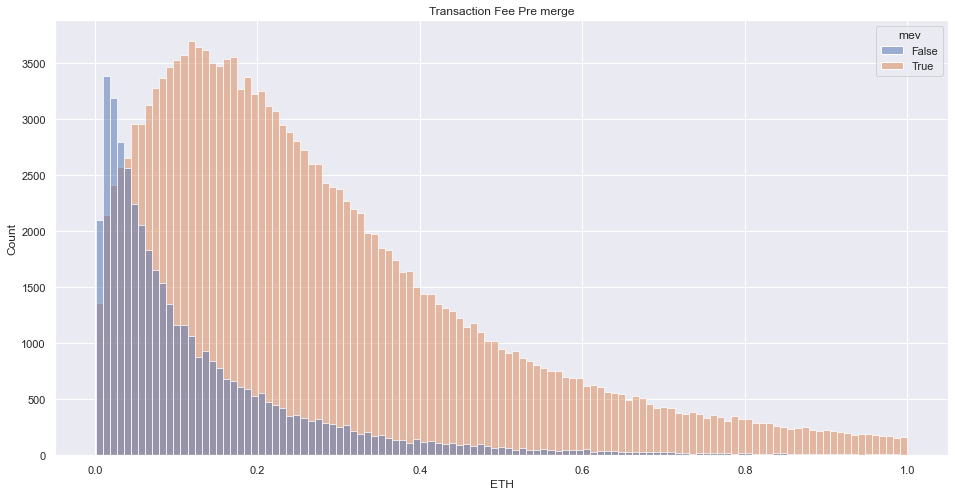

In [1252]:
fig = plt.figure(figsize=(16,8))
sns.histplot(data=tx_fee[tx_fee.timestamp < merge_time], x="transaction_fees", hue="mev", stat='count', binrange=(0.001, 1))
plt.xlabel('ETH')
plt.title("Transaction Fee Pre merge")

Text(0.5, 1.0, 'Transaction Fee Post merge')

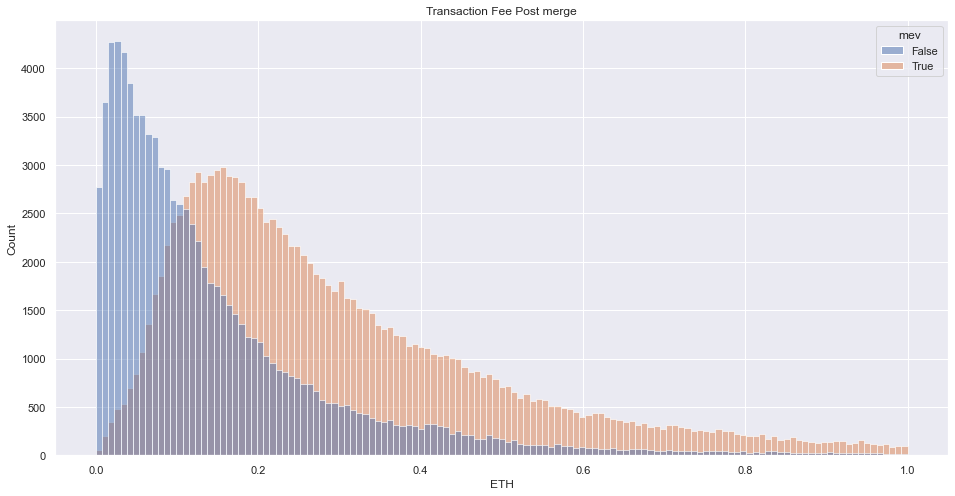

In [1253]:
fig = plt.figure(figsize=(16,8))
sns.histplot(data=tx_fee[tx_fee.timestamp > merge_time], x="transaction_fees", hue="mev", stat='count', binrange=(0, 1))
plt.xlabel('ETH')
plt.title("Transaction Fee Post merge")

#### MEV rewards vs block rewards?

In [1301]:
block_w_payload_w_tx_last.loc[block_w_payload_w_tx_last.mev_last_tx == True,'mev_value'] = block_w_payload_w_tx_last.loc[block_w_payload_w_tx_last.mev_last_tx == True, 'value']
block_w_payload_w_tx_last['mev_value'] = block_w_payload_w_tx_last['mev_value'].fillna(0).astype(float)

In [1302]:
block_w_payload_w_relay.loc[block_w_payload_w_relay.mev_relay_api == True,'mev_value'] = block_w_payload_w_relay.loc[block_w_payload_w_relay.mev_relay_api == True, 'value']
block_w_payload_w_relay['mev_value'] = block_w_payload_w_relay['mev_value'].fillna(0).astype(float)

In [1365]:
post_mev_rewards = block_w_payload_w_tx_last.merge(block_w_payload_w_relay[['mev_value', 'block_number', 'mev_relay_api', 'block_reward']], on=['block_number', 'block_reward'])

In [1366]:
post_mev_rewards['mev'] = post_mev_rewards['mev_last_tx'].fillna(False) + post_mev_rewards['mev_relay_api'].fillna(False)

In [1367]:
post_mev_rewards['mev_value'] = post_mev_rewards['mev_value_x'] + post_mev_rewards['mev_value_y']

In [1368]:
post_mev_rewards['mev_value'] = post_mev_rewards['mev_value'] / (10**(18))

In [1369]:
post_mev_rewards = post_mev_rewards[post_mev_rewards.timestamp > merge_time]

In [1370]:
post_mev_rewards['block_reward'] = post_mev_rewards['block_reward'] / (10**(18))

In [1372]:
avg_block_reward = post_mev_rewards[(post_mev_rewards.timestamp > merge_time) & (post_mev_rewards.block_reward > 0)].set_index('timestamp')['block_reward'].resample('H').mean().reset_index().rename(columns={'block_reward': 'avg_block_reward'})

In [1373]:
avg_mev_reward = post_mev_rewards.set_index('timestamp')['mev_value'].resample('H').mean().reset_index().rename(columns={'mev_value': 'avg_mev_reward'})

In [1386]:
avg_mev_reward['avg_mev_reward'] = pd.concat([avg_mev_reward['avg_mev_reward'], avg_block_reward['avg_block_reward']], axis=1).max(axis=1)

Text(0.5, 1.0, 'EL Block vs MEV Rewards Post merge')

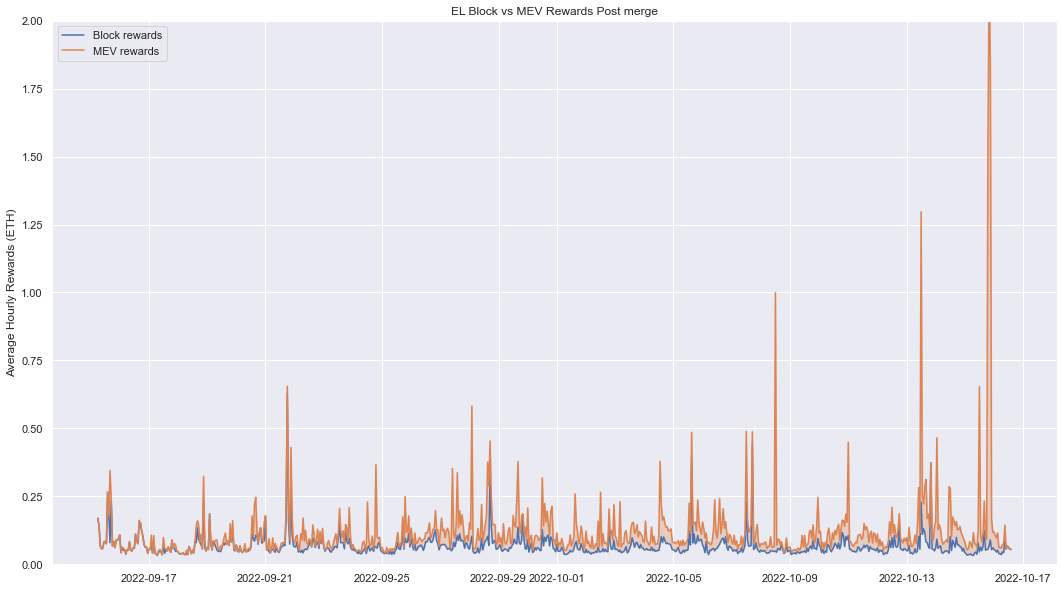

In [1400]:
fig, ax3 = plt.subplots(figsize=(18,10))

plt.plot(avg_block_reward['timestamp'], avg_block_reward['avg_block_reward'], label='Block rewards')
plt.plot(avg_mev_reward.timestamp, avg_mev_reward.avg_mev_reward, label='MEV rewards')
ax3.fill_between(avg_block_reward['timestamp'], avg_mev_reward.avg_mev_reward, avg_block_reward['avg_block_reward'], color='C1', alpha=0.3)
plt.legend()
plt.ylim(0, 2)
plt.ylabel('Average Hourly Rewards (ETH)')
plt.title("EL Block vs MEV Rewards Post merge")

In [1404]:
post_mev_rewards.loc[post_mev_rewards.mev == True, 'type'] = 'MEV Rewards'
post_mev_rewards.loc[post_mev_rewards.mev == False, 'type'] = 'Block rewards'

In [1406]:
post_mev_rewards.loc[post_mev_rewards.mev == True, 'EL rewards'] = post_mev_rewards['mev_value']
post_mev_rewards.loc[post_mev_rewards.mev == False, 'EL rewards'] = post_mev_rewards['block_reward']

Text(0.5, 1.0, 'EL Block Reward vs MEV Rewards - Post merge')

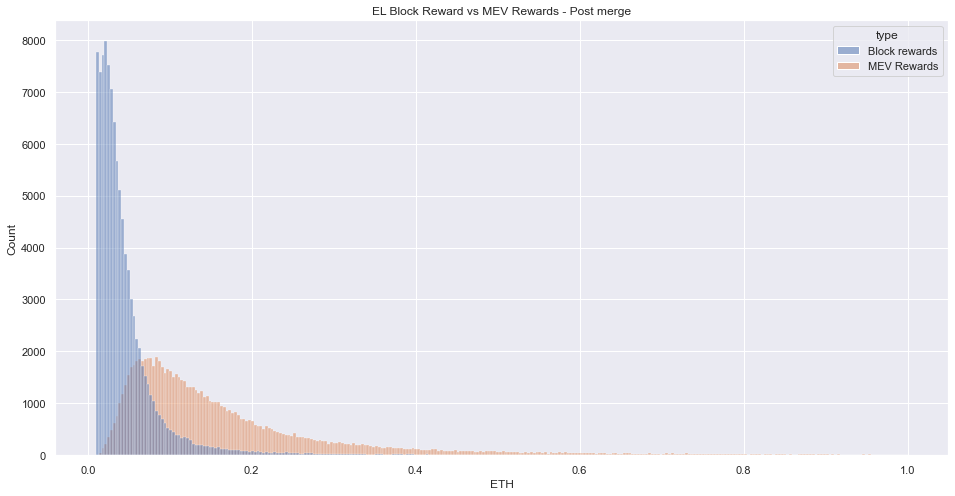

In [1409]:
fig = plt.figure(figsize=(16,8))
sns.histplot(data=post_mev_rewards, x="EL rewards", hue="type", binrange=(0.01, 1))
plt.xlabel('ETH')
plt.title("EL Block Reward vs MEV Rewards - Post merge")

Text(0.5, 1.0, 'EL Block Reward vs MEV Rewards - Post merge')

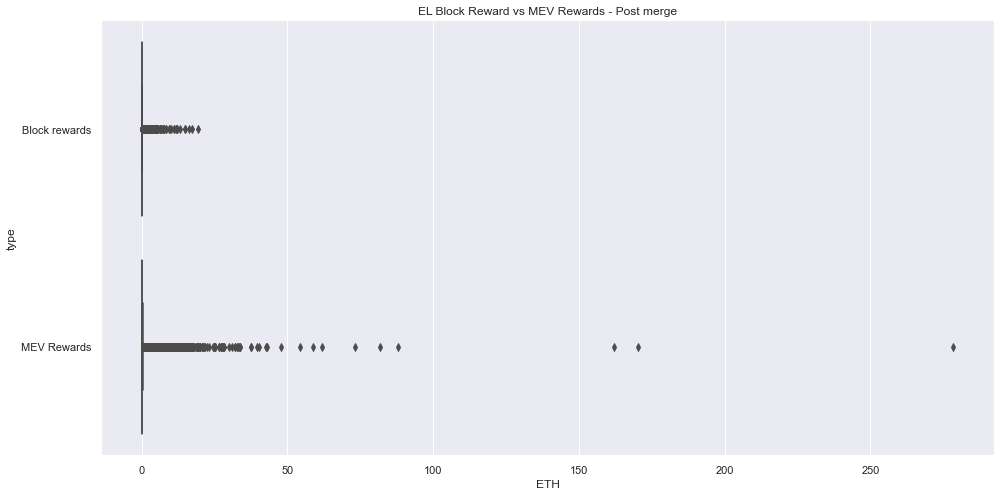

In [1464]:
fig = plt.figure(figsize=(16,8))
sns.boxplot(data=post_mev_rewards, x="EL rewards", y="type", orient="h")
plt.xlabel('ETH')
plt.title("EL Block Reward vs MEV Rewards - Post merge")